# Aula 2

In [13]:
from fbprophet import Prophet
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (20,8)
sns.set_style('darkgrid')

In [14]:
dados_sp = pd.read_csv('dados/dados_covid_sp', parse_dates=['datahora'])

In [15]:
dados_sp.head()

,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,...,media_movel_obitos,ano,obitos_3dias_depois,obitos_5dias_depois,obitos_7dias_depois,obitos_10dias_depois,obitos_12dias_depois,obitos_14dias_depois,obitos_16dias_depois,obitos_21dias_depois
0,São Paulo,3550308,25,2,2020-02-25,1,0,"8,424841e-03","0,0000000",0,...,NaN,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,São Paulo,3550308,26,2,2020-02-26,1,0,"8,424841e-03","0,0000000",0,...,NaN,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,São Paulo,3550308,27,2,2020-02-27,1,0,"8,424841e-03","0,0000000",0,...,NaN,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,São Paulo,3550308,28,2,2020-02-28,2,1,"1,684968e-02","0,0000000",0,...,NaN,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,São Paulo,3550308,29,2,2020-02-29,2,0,"1,684968e-02","0,0000000",0,...,NaN,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
def split_time_treino_teste(dados, x, y, periodo=None ,test_size=0.3):
    
    dados = dados.sort_values(x)
    
    df_treino = pd.DataFrame()
    df_teste = pd.DataFrame()
    
    if periodo == None:
        split_ponto = int(len(dados) * (1-test_size))
    else:
        split_ponto = len(dados) - periodo
        
    df_treino['ds'] = dados[x][0:split_ponto]
    df_teste['ds'] = dados[x][split_ponto:]
    df_treino['y'] = dados[y][0:split_ponto]
    df_teste['y_teste'] = dados[y][split_ponto:]
    
    return df_treino, df_teste

In [17]:
treino, teste = split_time_treino_teste(dados_sp, 'datahora', 'casos_novos')

# Desafio 08: Mudar os períodos de previsão e 
# Desafio 09: Explorar a documentação do Prophet e melhorar os gráficos.

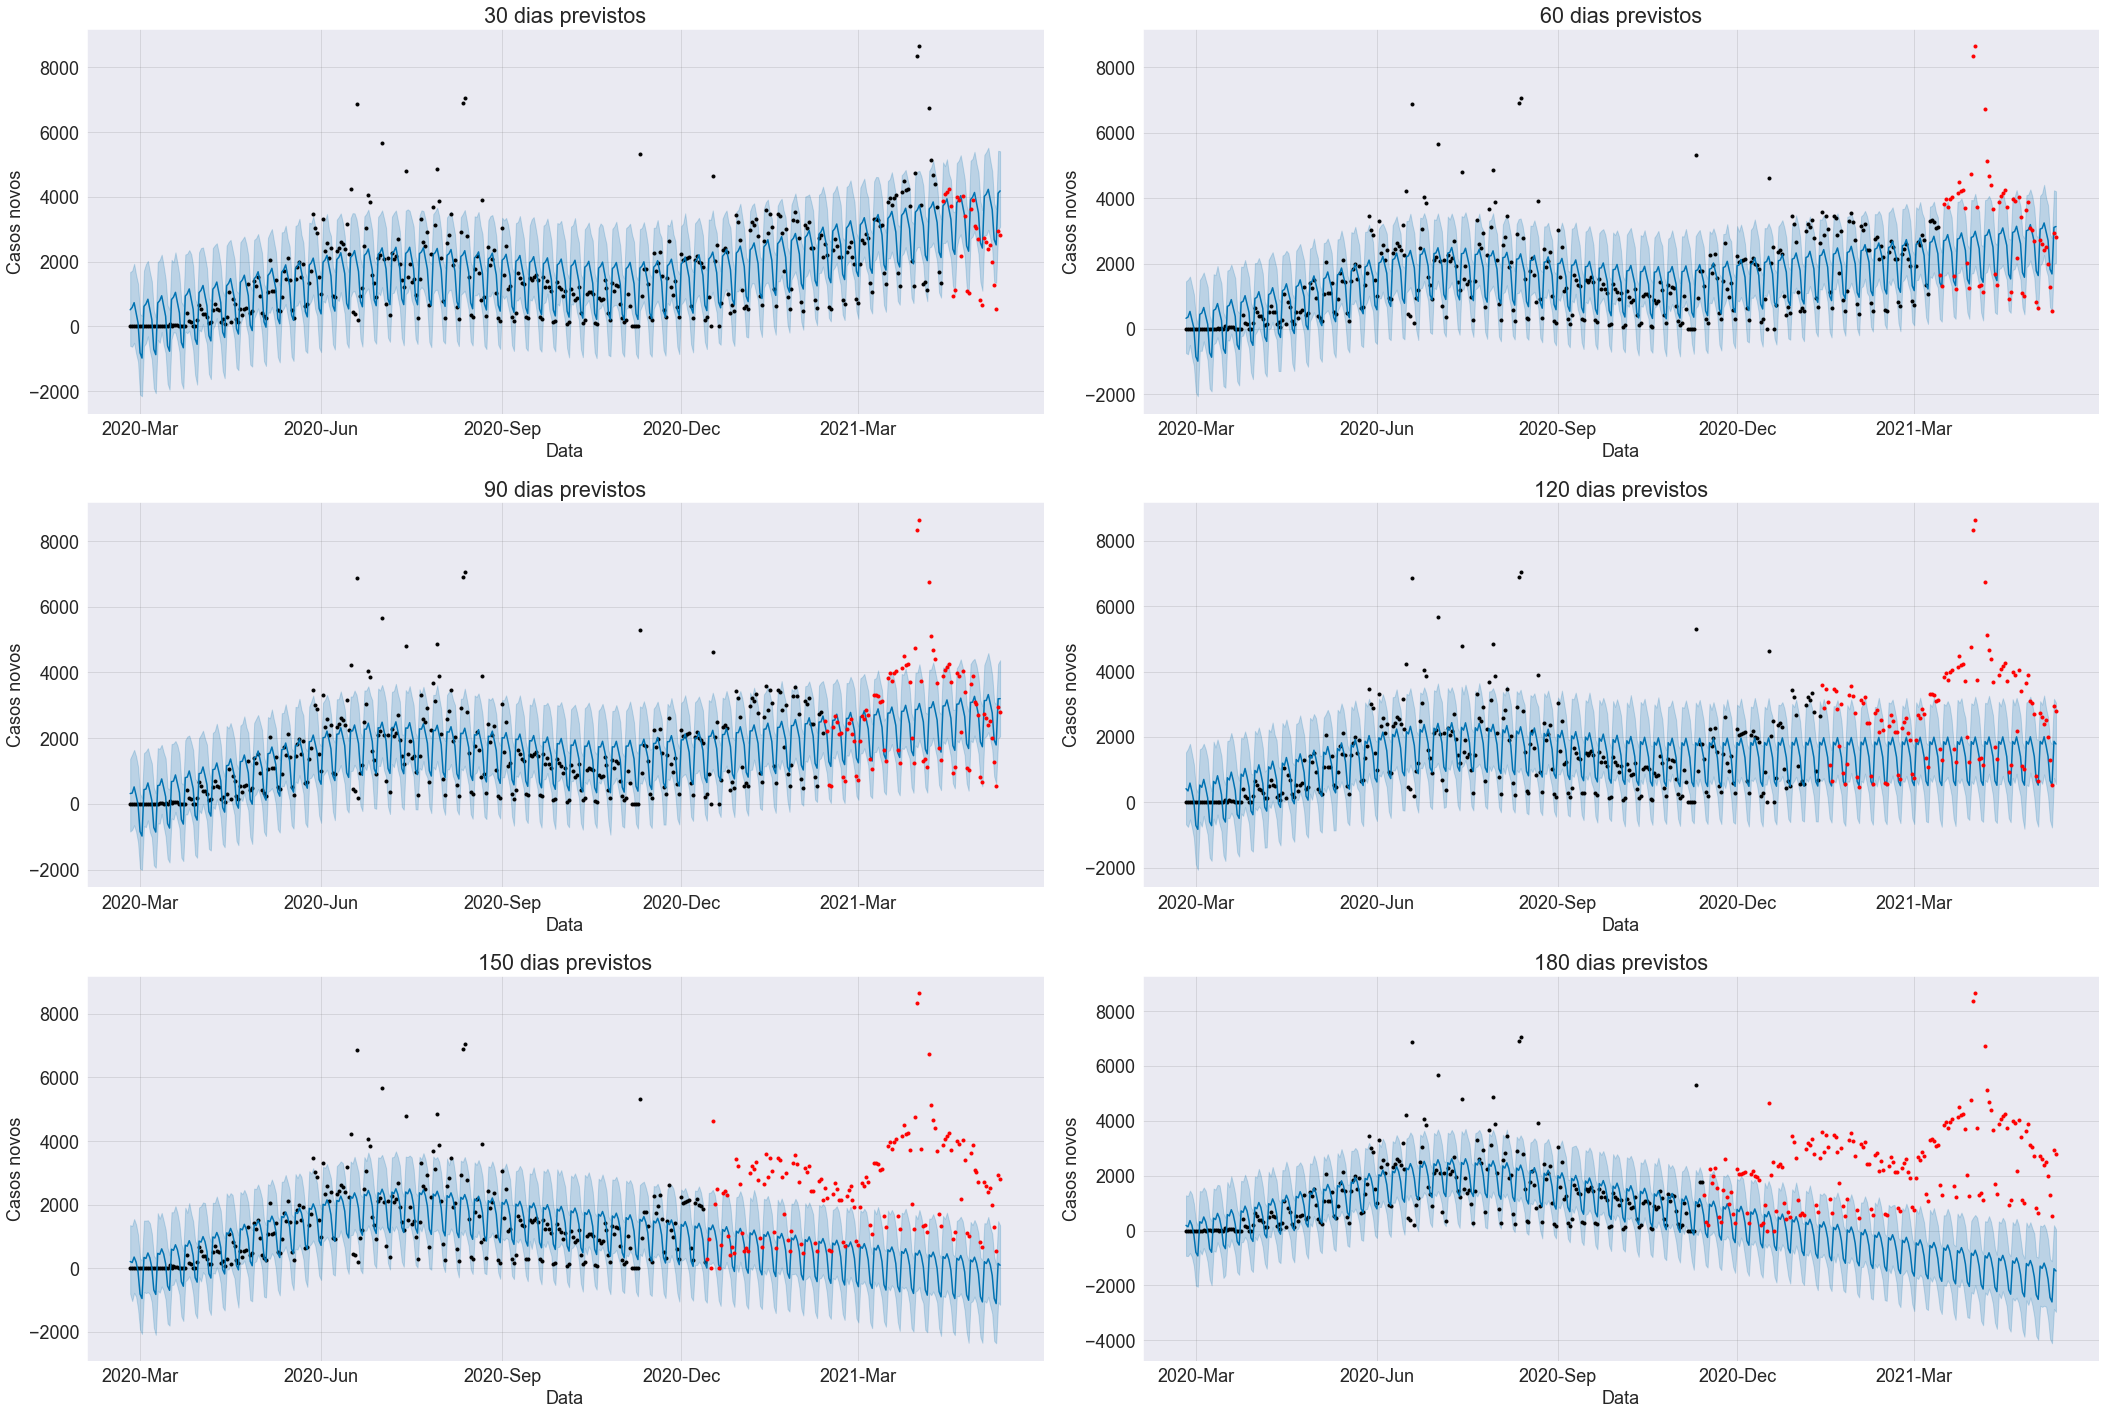

In [25]:
fig, ax = plt.subplots(3,2, figsize=(30,20))
i=0
j=0

for intervalo in range(30,210,30):
    
    treino, teste = split_time_treino_teste(dados_sp, 'datahora', 'casos_novos', periodo=intervalo)
    modelo = Prophet(daily_seasonality=False, yearly_seasonality=False)
    modelo.fit(treino)
    previsao = modelo.predict(modelo.make_future_dataframe(periods=intervalo))
    modelo.plot(previsao, xlabel='Data', ylabel='Casos novos', ax=ax[i,j])
    ax[i,j].plot(teste['ds'], teste['y_teste'], '.r')
    ax[i,j].set_title(f'{intervalo} dias previstos')
    plt.sca(ax[i,j])
    plt.xticks(pd.date_range('2020-03-01', '2021-05-01', freq='3MS'),pd.date_range('2020-03-01', '2021-05-01', freq='3MS').strftime('%Y-%b'))
    if j == 1:
        j=0
        i+=1
    else:
        j+=1
plt.savefig('dias_previstos_casos_novos')

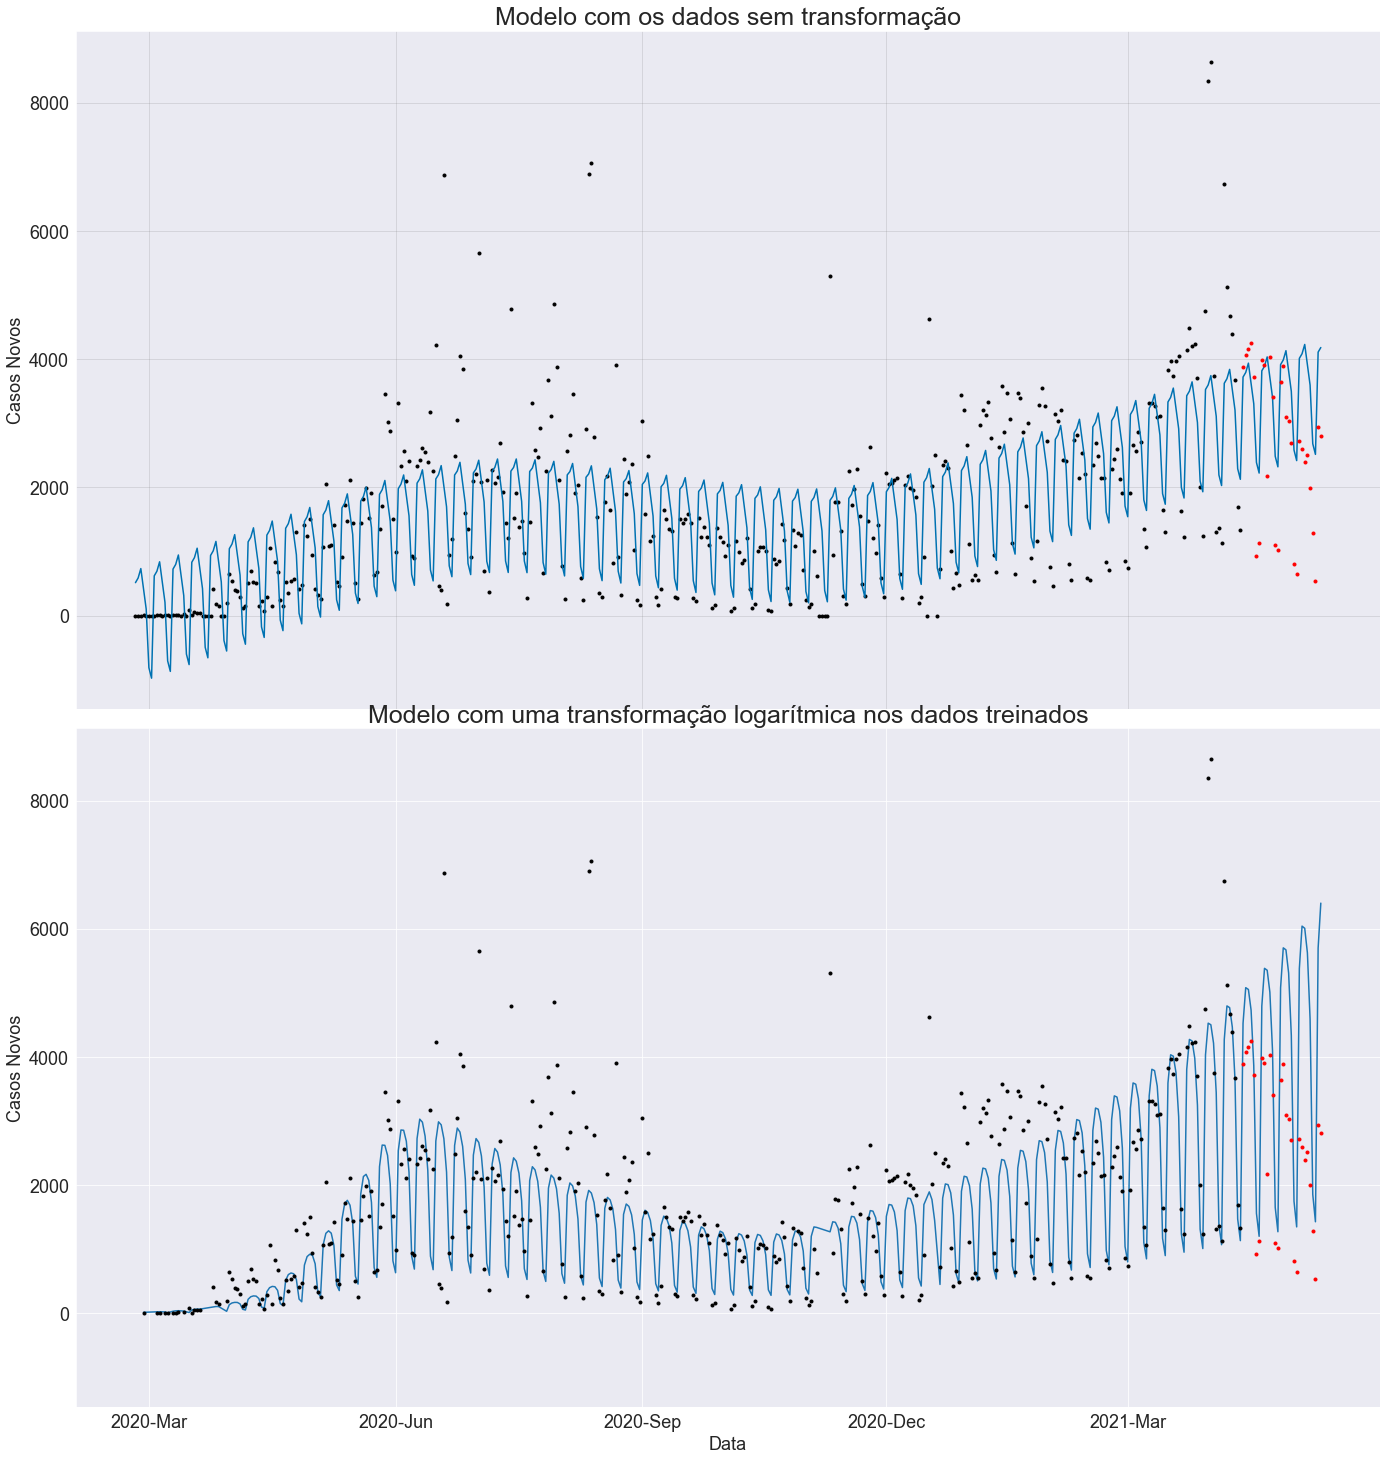

In [26]:
fig, ax=plt.subplots(2, figsize=(20,20), sharex=True, sharey=True)


treino, teste = split_time_treino_teste(dados_sp, 'datahora', 'casos_novos', periodo=30)
modelo = Prophet(daily_seasonality=False, yearly_seasonality=False)
modelo.fit(treino)
previsao = modelo.predict(modelo.make_future_dataframe(periods=30))
modelo.plot(previsao, xlabel='', ylabel='Casos Novos', ax=ax[0], uncertainty=False)
ax[0].plot(teste['ds'], teste['y_teste'], '.r')
ax[0].set_title('Modelo com os dados sem transformação', fontsize=25)

casos_novos_log = dados_sp[['datahora', 'casos_novos']]
casos_novos_log = casos_novos_log[casos_novos_log['casos_novos'] !=0]  
casos_novos_log['casos_novos'] = np.log(casos_novos_log['casos_novos'])

treino_log, teste_log = split_time_treino_teste(casos_novos_log, 'datahora', 'casos_novos', periodo=30)
modelo_log = Prophet(daily_seasonality=False, yearly_seasonality=False)
modelo_log.fit(treino_log)
previsao_log = modelo_log.predict(modelo_log.make_future_dataframe(periods=30))
ax[1].plot(previsao_log['ds'], np.exp(previsao_log['yhat']))
ax[1].plot(treino_log['ds'], np.exp(treino_log['y']),'.', color='black')
ax[1].plot(teste_log['ds'], np.exp(teste_log['y_teste']), '.r')
ax[1].set_title('Modelo com uma transformação logarítmica nos dados treinados', fontsize=25)
plt.xticks(pd.date_range('2020-03-01', '2021-05-01', freq='3MS'),pd.date_range('2020-03-01', '2021-05-01', freq='3MS').strftime('%Y-%b'))
plt.xlabel('Data')
plt.ylabel('Casos Novos')
plt.savefig('modelos_casos_novos_log_x_normal')
plt.show()

# Desafio 10: Fazer todo o processo de previsão para o número de casos acumulados

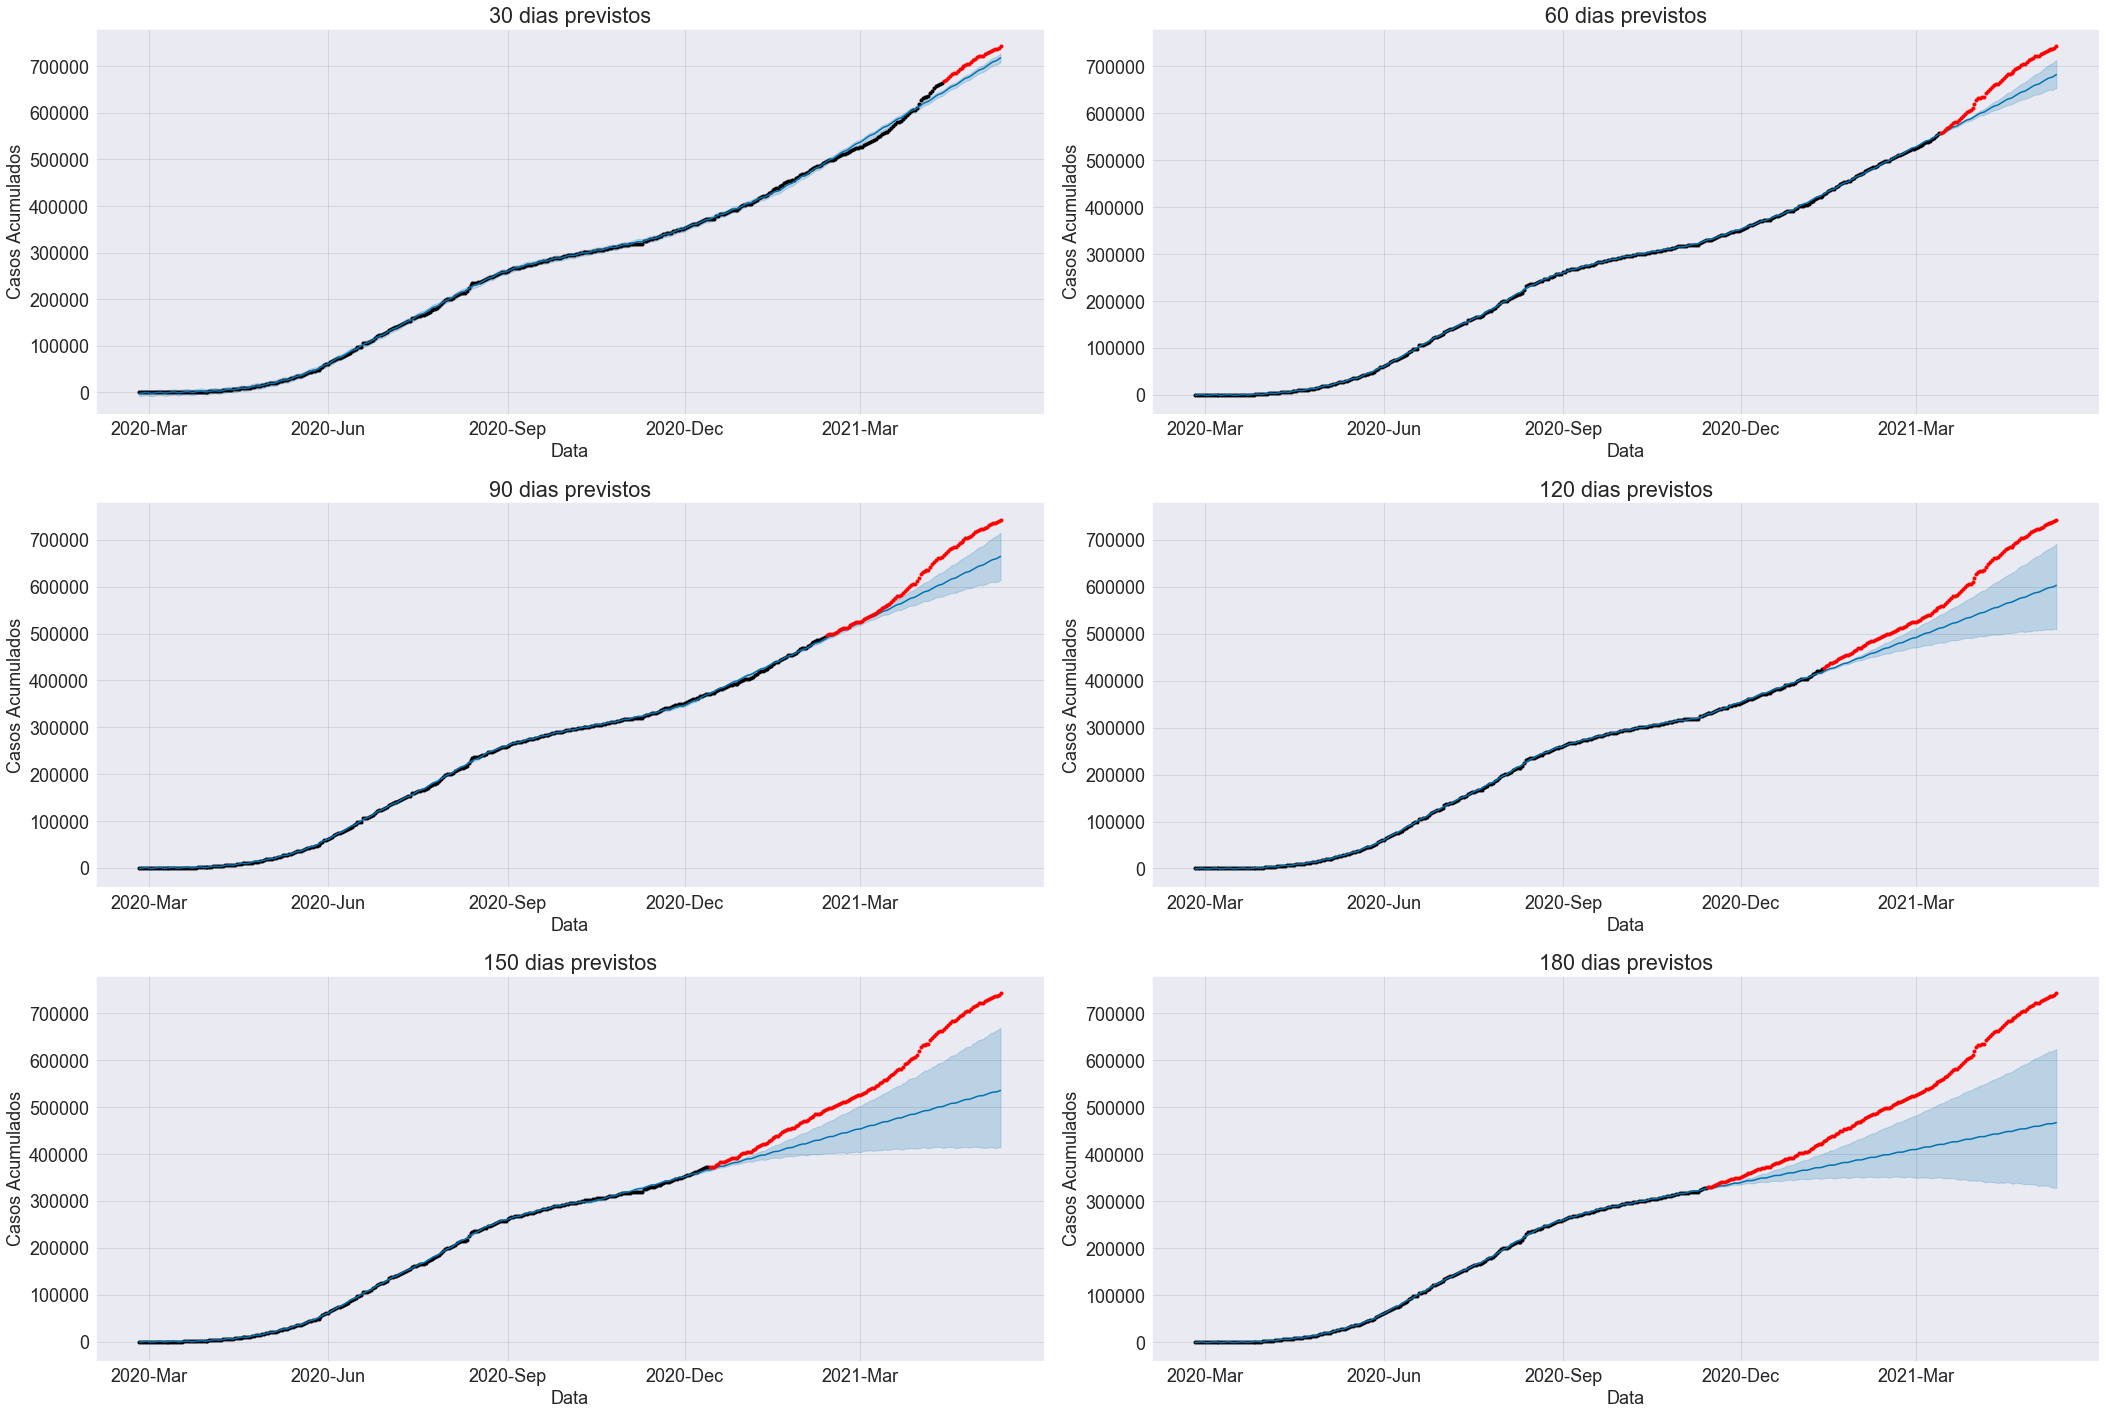

In [27]:
fig, ax = plt.subplots(3,2, figsize=(30,20))
i=0
j=0

for intervalo in range(30,210,30):
    
    treino, teste = split_time_treino_teste(dados_sp, 'datahora', 'casos', periodo=intervalo)
    modelo = Prophet(daily_seasonality=False, yearly_seasonality=False)
    modelo.fit(treino)
    previsao = modelo.predict(modelo.make_future_dataframe(periods=intervalo))
    modelo.plot(previsao, xlabel='Data', ylabel='Casos Acumulados', ax=ax[i,j])
    ax[i,j].plot(teste['ds'], teste['y_teste'], '.r')
    ax[i,j].set_title(f'{intervalo} dias previstos')
    plt.sca(ax[i,j])
    plt.xticks(pd.date_range('2020-03-01', '2021-05-01', freq='3MS'),pd.date_range('2020-03-01', '2021-05-01', freq='3MS').strftime('%Y-%b'))
    if j == 1:
        j=0
        i+=1
    else:
        j+=1
plt.savefig('dias_previstos_casos_acumulados')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


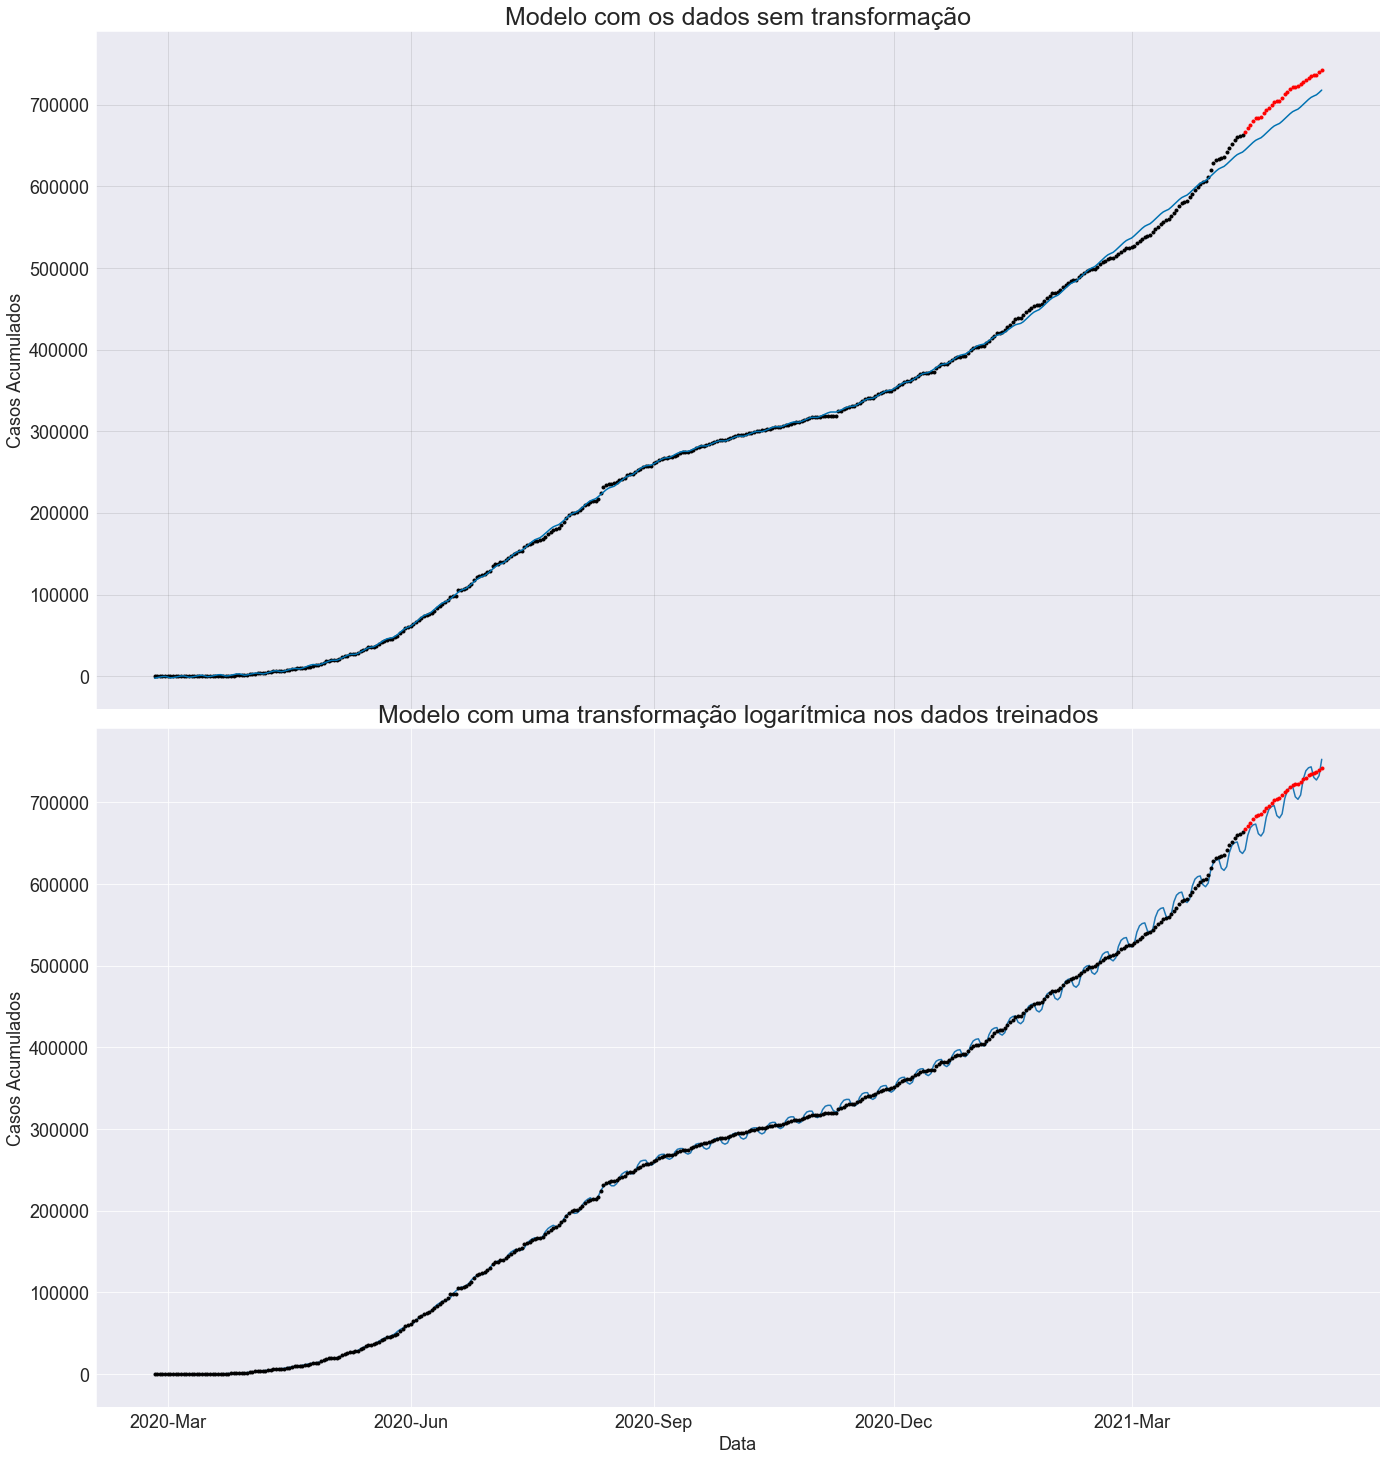

In [28]:
fig, ax=plt.subplots(2, figsize=(20,20), sharex=True, sharey=True)


treino, teste = split_time_treino_teste(dados_sp, 'datahora', 'casos', periodo=30)
modelo = Prophet(daily_seasonality=False, yearly_seasonality=False)
modelo.fit(treino)
previsao = modelo.predict(modelo.make_future_dataframe(periods=30))
modelo.plot(previsao, xlabel='', ylabel='Casos Acumulados', ax=ax[0], uncertainty=False)
ax[0].plot(teste['ds'], teste['y_teste'], '.r')
ax[0].set_title('Modelo com os dados sem transformação', fontsize=25)

casos_log = dados_sp[['datahora', 'casos']] 
casos_log['casos'] = np.log(casos_log['casos'])

treino_log, teste_log = split_time_treino_teste(casos_log, 'datahora', 'casos', periodo=30)
modelo_log = Prophet()
modelo_log.fit(treino_log)
previsao_log = modelo_log.predict(modelo_log.make_future_dataframe(periods=30))
ax[1].plot(previsao_log['ds'], np.exp(previsao_log['yhat']))
ax[1].plot(treino_log['ds'], np.exp(treino_log['y']),'.', color='black')
ax[1].plot(teste_log['ds'], np.exp(teste_log['y_teste']), '.r')
ax[1].set_title('Modelo com uma transformação logarítmica nos dados treinados', fontsize=25)
plt.xticks(pd.date_range('2020-03-01', '2021-05-01', freq='3MS'),pd.date_range('2020-03-01', '2021-05-01', freq='3MS').strftime('%Y-%b'))
plt.xlabel('Data')
plt.ylabel('Casos Acumulados')
plt.savefig('modelos_casos_acumulados_log_x_normal')
plt.show()

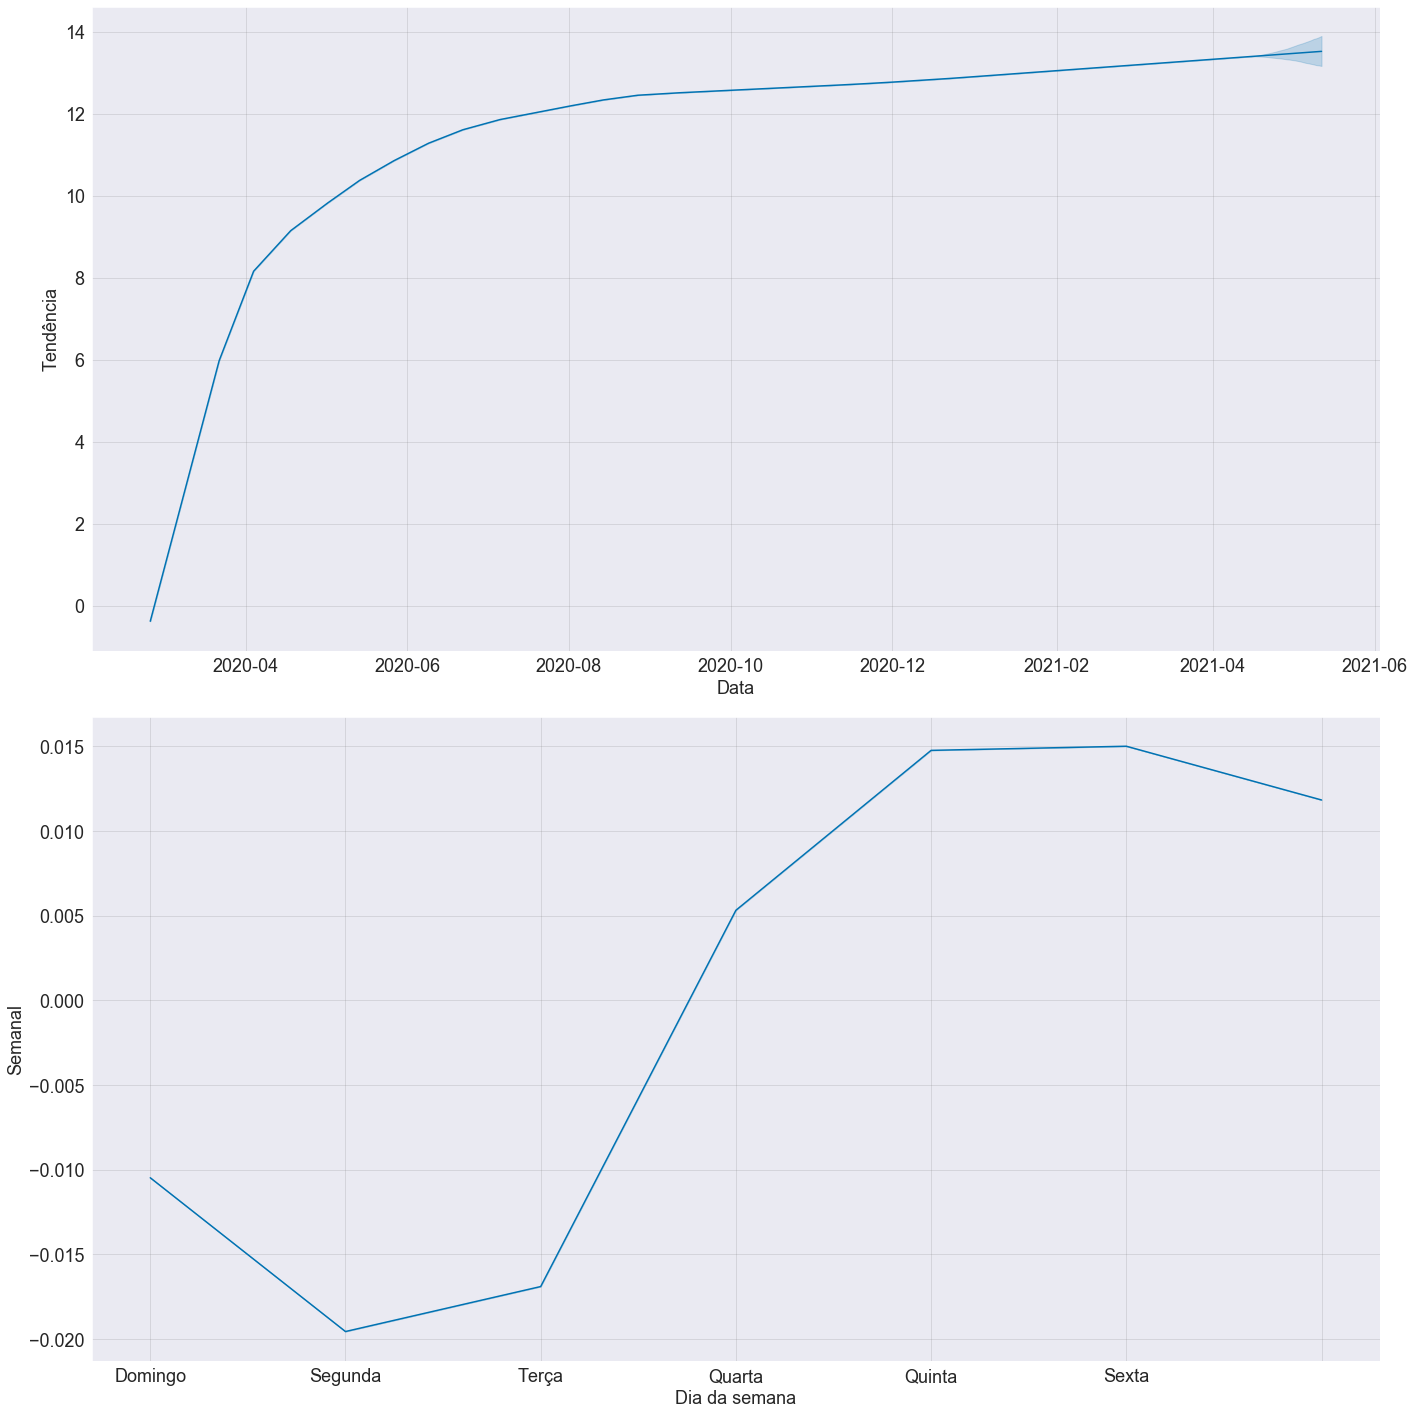

In [22]:
componets_fig = modelo_log.plot_components(previsao_log, figsize=(20,20))
axes = componets_fig.get_axes()
axes[0].set_ylabel('Tendência')
axes[0].set_xlabel('Data')
axes[1].set_ylabel('Semanal')
axes[1].set_xlabel('Dia da semana')
plt.sca(axes[1])
plt.xticks(range(0,7), ['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta'])
plt.show()